**url**

https://www.airbus.com/en/search?f%5B0%5D=type%3Apress%20releases&sort=field_date&order=desc

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from selenium.webdriver.common.by import By
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

Autosaving every 1 seconds


In [2]:
#driver for operation
from webdriver_manager.chrome import ChromeDriverManager
option = webdriver.ChromeOptions()
# option.add_argument('headless')
driver = webdriver.Chrome(ChromeDriverManager().install(),options=option)



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Driver [C:\Users\AKSHAY SATPUTE\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [3]:
SITE_NAME='Airbus'

DOMAIN = "https://www.airbus.com"

SITE_LINK="https://www.airbus.com/en/search?f%5B0%5D=type%3Apress%20releases&sort=field_date&order=desc"

In [4]:
def parse_webpage_bs(search_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0"}
    try:
        site_request = requests.get(search_url, headers=headers, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        site_request = None
    if site_request != None and site_request.status_code==200:
        site_soup = bs4.BeautifulSoup(site_request.content, "lxml")
    else:
        site_soup = None
    return site_soup

def remove_esc_chars(text):
    return text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

def get_text(link): 
    g = Goose()
    article_extract = g.extract(url=link)
    article = remove_esc_chars(article_extract.cleaned_text)
    meta_data = remove_esc_chars(article_extract.meta_description)
    whole_data = meta_data+article
    text = whole_data.strip()
    
    if textstat.lexicon_count(text, removepunct=True) < 5:
        try:
            response = requests.get(link)
            text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

            if textstat.lexicon_count(text, removepunct=True) < 5:
                texts = ""
                r = requests.get(link)
                filename = Path('temp.pdf')
                filename.write_bytes(r.content)

                pages = convert_from_path('temp.pdf', 500)
                for x in pages:
                    x.save("temp.jpg")
                    output = reader.readtext("temp.jpg")
                    for o in output:
                        texts += o[1]

                text = remove_esc_chars(texts)
                
                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    soup = parse_webpage_bs(link)
                    if soup!= None:
                        ps = soup.findAll('p')
                        for p in ps:
                            texts+= p.text

                    text = remove_esc_chars(texts)
        except:
            text = ""
    
    return text

def get_text_whn_cookies(link):
    retry_count = 3
    text = get_text(link)
    
    if textstat.lexicon_count(text, removepunct=True) < 5:
        while retry_count >0:
            driver.get(link)
            try:
                driver.find_element(By.XPATH,'''//*[@id="onetrust-accept-btn-handler"]''').click() 
            except:
                pass
            ps = driver.find_element(By.XPATH,'''//div[@class="col-md-12 col-lg-7"]''').text
            text = remove_esc_chars(ps).strip()
            if len(text) < 10:
                retry_count -= 1
                time.sleep(10)
            else:
                break
                
            if retry_count == 0:
                text = ""
                
    return text

def get_thumbnail(link):  
    #accepting cookies
    try :
        driver.get(link)
        driver.find_element(By.XPATH,'''//*[@id="onetrust-accept-btn-handler"]''').click() 
    except :
        pass
    
    try:                 
        thumbnail = driver.find_element(By.XPATH,'''//*[@id="block-airbus-brand-content"]/div[1]/div/div[4]/div/div/div/article/div/picture/img''').get_attribute("src")
    except :
        thumbnail = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5d/Airbus_Logo_2017.svg/1920px-Airbus_Logo_2017.svg.png"
        
    return thumbnail

In [5]:
article_list = []

pagination = 0
last_page = 0

while pagination <= last_page:
    page_url = f"https://www.airbus.com/en/search?search=&items_per_page=48&f%5B0%5D=type%3Apress%20releases&sort=field_date&order=desc&f%5B0%5D=type%3Apress%20releases&page={pagination}"
    driver.get(page_url)

    #accepting cookies
    try :
        driver.find_element(By.XPATH,'''//*[@id="onetrust-accept-btn-handler"]''').click() 
    except :
        pass
    
    #getting last page count
    if last_page <= 0:
        lp = driver.find_element(By.XPATH,'''//*[@id="block-airbus-brand-content"]/div/div/div[3]/div[1]/footer''').text
        last_page_count = round(int(lp.strip().split(' ')[-2])/48)
        last_page = last_page_count
    
    #creating empty lists to append data 
    published_dates,titles,texts,links,thumbnails,authors = [],[],[],[],[],[]
     
    titles_t = driver.find_elements(By.XPATH,'''//a[@class="ds-textbox__title card-title"]''')
    for t in titles_t:
        titles.append(t.text.strip())

    published_dates_d = driver.find_elements(By.XPATH,f'''//small[@class="text-muted ds-textbox__body__date"]''')
    for d in published_dates_d:
        published_dates.append(d.text.strip())

    links_l = driver.find_elements(By.XPATH,'''//a[@class="ds-textbox__title card-title"]''')
    for l in links_l:
        links.append(l.get_attribute('href'))

        
    for link in links :
        thumbnail = get_thumbnail(link)
        thumbnails.append(thumbnail)
        
        text = get_text_whn_cookies(link)
        texts.append(text)
        
        author = SITE_NAME
        authors.append(author)
      
    #zippig all the data togather 
    zipped = list(zip(published_dates,titles,texts,links,thumbnails,authors))
    
    #unwinding and appending to the main list
    for published_date,title,text,link,thumbnail,author in zipped:
        article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
        article_list.append(article)
        print(published_date,title)
    
    #my condition to break the loop 
    if pagination == 1:
        break
        
    pagination +=1

02 June 2022 Airbus strengthens its cybersecurity activities
01 June 2022 Japan’s first SAF helicopter flight with H215
30 May 2022 Airbus Foundation launches the first Discovery Science Week in Spain
26 May 2022 Airbus increases its UK innovation footprint to develop new hydrogen technologies
24 May 2022 Polar Ice and Snow monitoring mission CRISTAL on track
23 May 2022 U.S. Army awards Airbus contract for Continued Logistics Support
19 May 2022 Airbus to further develop LISA gravitational wave observatory mission
18 May 2022 Final Pléiades Neo satellites ready to join rest of family
12 May 2022 ITA Airways becomes first Italian A350 operator
10 May 2022 Airbus partners with MAGicALL to develop the electric motors of CityAirbus NextGen
09 May 2022 With NIRSpec, Webb is set to unveil a new Universe
04 May 2022 Airbus reports First Quarter (Q1) 2022 results
04 May 2022 Airbus lays the foundations for future urban air mobility in Germany with the Air Mobility Initiative
04 May 2022 Airbu

In [6]:
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,02 June 2022,Airbus strengthens its cybersecurity activities,Airbus is taking steps to strengthen and grow ...,https://www.airbus.com/en/newsroom/press-relea...,https://mediaassets.airbus.com/permalinks/5551...,Airbus
1,01 June 2022,Japan’s first SAF helicopter flight with H215,Airbus Helicopters in Japan and Japan’s leadin...,https://www.airbus.com/en/newsroom/press-relea...,https://www.airbus.com/sites/g/files/jlcbta136...,Airbus
2,30 May 2022,Airbus Foundation launches the first Discovery...,The Airbus Foundation has launched the first D...,https://www.airbus.com/en/newsroom/press-relea...,https://mediaassets.airbus.com/permalinks/5757...,Airbus
3,26 May 2022,Airbus increases its UK innovation footprint t...,Airbus is strengthening its presence in the UK...,https://www.airbus.com/en/newsroom/press-relea...,https://mediaassets.airbus.com/permalinks/5539...,Airbus
4,24 May 2022,Polar Ice and Snow monitoring mission CRISTAL ...,The Copernicus Polar Ice and Snow Topography A...,https://www.airbus.com/en/newsroom/press-relea...,https://mediaassets.airbus.com/permalinks/5181...,Airbus


24 May 2022 Polar Ice and Snow monitoring mission CRISTAL on track

Airbus https://www.airbus.com/en/newsroom/press-releases/2022-05-polar-ice-and-snow-monitoring-mission-cristal-on-track


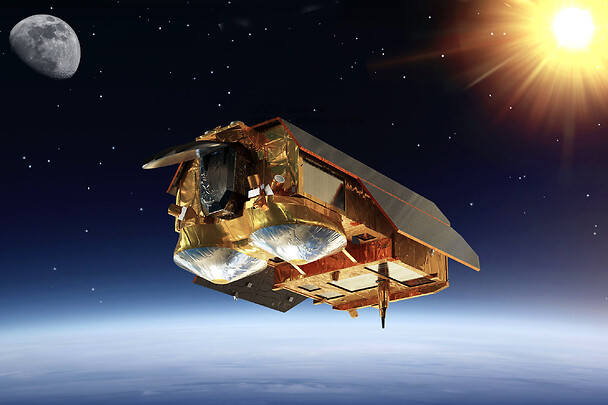


The Copernicus Polar Ice and Snow Topography Altimetry mission CRISTAL is clearly on track.Friedrichshafen, 24 May 2022 - The Copernicus Polar Ice and Snow Topography Altimetry mission CRISTAL is clearly on track. Following an intensive review process the European Space Agency ESA has confirmed that the preliminary design of the satellite meets all system requirements.  CRISTAL will carry an advanced multi-frequency altimeter that will measure sea ice thickness and ice sheet elevations - key climate change indicators. The CRISTAL altimeter will for the first time measure snow coverage of the ice sheets which will improve data quality significantly compared to its predecessor CryoSat-2. These data will support maritime operations in polar oceans and contribute to a better understanding of climate processes.  The Preliminary Design Review (PDR) was organised using a new more collaborative format. As a first step an extensive review by over 60 ESA engineers of a comprehensive data packag

In [7]:
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    display(Image.open(io.BytesIO(requests.get(temp_df.iloc[iloc_no]['thumbnail']).content)))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [8]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [9]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        os.remove("temp.jpg")
        os.remove("temp.pdf")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

No trash found
